<a href="https://colab.research.google.com/github/mohitraosatya/quantum-ecosystem-optimizer/blob/main/Amazon_QuantumEcoEvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install amazon-braket-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 537.8/537.8 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.5/541.5 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 8.9 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.2-py3-none-any.whl size=144544 sha256=7023a0f4ee60d2aee880c2af7551bc277512

In [9]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.8 MB/s eta 0:00:00


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from braket.circuits import Circuit
from braket.devices import LocalSimulator
import random
from deap import base, creator, tools, algorithms

In [11]:
def create_quantum_ecosystem_circuit(params):
    """
    Create a parameterized quantum circuit representing a two-species ecosystem.

    :param params: List or array of parameters. For example:
                   [theta_h, theta_rx, theta_ry, theta_cz_angle]
    :return: A Braket Circuit object.
    """
    # Unpack parameters
    theta_h, theta_rx, theta_ry, theta_extra = params  # you can expand with more parameters

    circuit = Circuit()

    # Apply an initial Hadamard on qubit 0 to create superposition (species A)
    circuit.h(0)

    # Apply parameterized rotations:
    # For species A (qubit 0)
    circuit.rx(0, theta_rx)
    circuit.ry(0, theta_h)

    # For species B (qubit 1), also put in superposition
    circuit.h(1)
    circuit.rx(1, theta_ry)

    # Entangling operation simulating interaction between species A and B
    circuit.cz(0,1)

    # Extra rotation to further modulate interaction dynamics
    circuit.rz(0, theta_extra)

    return circuit


In [12]:
def simulate_circuit(circuit, shots=1000):
    """
    Run the provided circuit on the local simulator and return measurement counts.
    """
    device = LocalSimulator()
    task = device.run(circuit, shots=shots)
    result = task.result()
    return result.measurement_counts

def compute_species_population(counts):
    """
    Convert measurement counts into species populations.
    For a two-qubit system: bitstring '00', '01', '10', '11' represent different population states.
    This example calculates an approximate population density for each species.
    """
    total_shots = sum(counts.values())
    pop_species_A = 0.0
    pop_species_B = 0.0

    for bitstr, count in counts.items():
        # Assume the first bit represents species A and second represents species B.
        # For example, '0' means low population and '1' means high population.
        pop_species_A += count * int(bitstr[0])
        pop_species_B += count * int(bitstr[1])

    return pop_species_A / total_shots, pop_species_B / total_shots

def fitness_function(params):
    """
    Evaluate the fitness of a candidate circuit.

    Fitness is defined here as the closeness of species populations to an ideal balance
    (e.g., both near 0.5 in a normalized scale), penalized for extreme divergences.
    """
    circuit = create_quantum_ecosystem_circuit(params)
    counts = simulate_circuit(circuit)
    pop_A, pop_B = compute_species_population(counts)

    # Ideal balance (you can change these targets as needed)
    target_A, target_B = 0.5, 0.5
    # Fitness: lower absolute differences yield higher fitness.
    fitness = - (abs(pop_A - target_A) + abs(pop_B - target_B))
    return (fitness,)

# Test the simulation with an example parameter set:
test_params = [0.7, 1.2, 0.8, 0.5]  # Example values; these will be optimized.
print("Test fitness:", fitness_function(test_params))


Test fitness: (-0.353,)


In [14]:
# Define the optimization problem using DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # We maximize fitness.
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator: generate a random number between defined bounds for each parameter.
# For our example, assume parameters range from 0 to 2π.
BOUND_LOW, BOUND_UP = 0, 6.283
NUM_PARAMS = 4

toolbox.register("attr_float", random.uniform, BOUND_LOW, BOUND_UP)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=NUM_PARAMS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the evaluation function.
toolbox.register("evaluate", fitness_function)
# Use standard genetic operators: crossover and mutation.
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.3, indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)

# Create initial population:
population = toolbox.population(n=20)

# Set parameters for evolution:
NGEN = 30  # number of generations
CXPB = 0.6  # crossover probability
MUTPB = 0.3  # mutation probability

# Store best fitness per generation for visualization.
best_fitness_over_time = []


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [15]:
import time

start_time = time.time()
for gen in range(NGEN):
    print(f"-- Generation {gen} --")

    # Evaluate all individuals in the population.
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Record best fitness.
    best_ind = tools.selBest(population, 1)[0]
    best_fitness_over_time.append(best_ind.fitness.values[0])
    print("  Best fitness:", best_ind.fitness.values[0])

    # Select the next generation individuals.
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring.
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness.
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace the old population with the offspring
    population[:] = offspring

end_time = time.time()
print("Evolution completed in", end_time - start_time, "seconds")


-- Generation 0 --
  Best fitness: -0.03700000000000003
-- Generation 1 --
  Best fitness: -0.04199999999999998
-- Generation 2 --
  Best fitness: -0.010000000000000009
-- Generation 3 --
  Best fitness: -0.01200000000000001
-- Generation 4 --
  Best fitness: -0.013000000000000012
-- Generation 5 --
  Best fitness: -0.01100000000000001
-- Generation 6 --
  Best fitness: -0.0040000000000000036
-- Generation 7 --
  Best fitness: -0.0020000000000000018
-- Generation 8 --
  Best fitness: -0.01100000000000001
-- Generation 9 --
  Best fitness: -0.0030000000000000027
-- Generation 10 --
  Best fitness: -0.010000000000000009
-- Generation 11 --
  Best fitness: -0.0050000000000000044
-- Generation 12 --
  Best fitness: -0.007000000000000006
-- Generation 13 --
  Best fitness: -0.009000000000000008
-- Generation 14 --
  Best fitness: -0.0010000000000000009
-- Generation 15 --
  Best fitness: -0.006000000000000005
-- Generation 16 --
  Best fitness: -0.0040000000000000036
-- Generation 17 --
  B

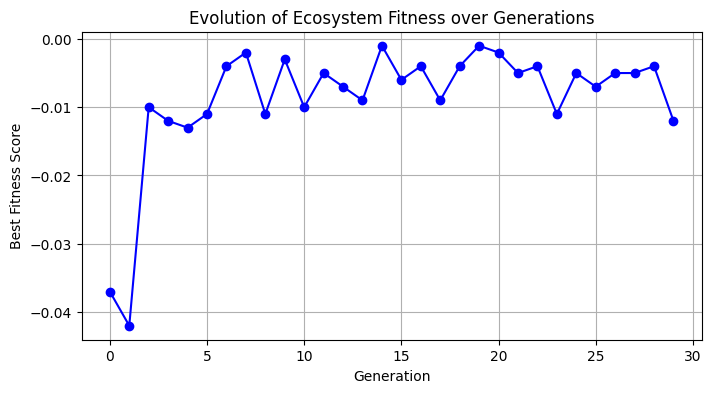

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(range(NGEN), best_fitness_over_time, marker='o', linestyle='-', color='b')
plt.title("Evolution of Ecosystem Fitness over Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.grid(True)
plt.show()


In [18]:
best_individual = tools.selBest(population, 1)[0]
print("Best individual parameters:", best_individual)
print("Best individual fitness:", best_individual.fitness.values[0])


Best individual parameters: [3.132774063407237, 2.3511266101876114, 2.26920850234529, 4.95432177161591]
Best individual fitness: -0.0030000000000000027
